# Coursera Capstone Project - The Battle of Neighborhoods

## Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Load and Explore Dataset

In [2]:
with open('datasets/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Tranform the data into a pandas dataframe

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

### Use geopy library to get the latitude and longitude values of New York City

In [6]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [7]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [8]:
# Count number of neighborhood by group of borough
neighborhoods.groupby('Borough').count()

Neighborhood  Latitude  Longitude
Borough                                         
Bronx                    52        52         52
Brooklyn                 70        70         70
Manhattan                40        40         40
Queens                   81        81         81
Staten Island            63        63         63

## Foursquare API - Venues

In [9]:
CLIENT_ID = '21BYLPN1BNF0W4YZR1EMHCK2BZ0MYNXHGPVKZYNBQZYUY4SG' # your Foursquare ID
CLIENT_SECRET = 'A4UND5RAUBRHYGYCNINGXOMUMGXQUH55FEMQH1QAUZZ3TYUW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 21BYLPN1BNF0W4YZR1EMHCK2BZ0MYNXHGPVKZYNBQZYUY4SG
CLIENT_SECRET:A4UND5RAUBRHYGYCNINGXOMUMGXQUH55FEMQH1QAUZZ3TYUW


In [10]:
def getNearbyVenues(names, latitudes, longitudes, categoryId, radius=1000, LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}\
        &client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## For this project, I use only Manhattan dataset to reduce scope to analyze

In [11]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

In [12]:
# Thai Restaurant Category Id - 4bf58dd8d48988d149941735 
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   categoryId='4bf58dd8d48988d149941735'
                                  )
manhattan_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551              -73.910660   
1  Marble Hill              40.876551              -73.910660   
2    Chinatown              40.715618              -73.994279   
3    Chinatown              40.715618              -73.994279   
4    Chinatown              40.715618              -73.994279   

                Venue  Venue Latitude  Venue Longitude   Venue Category  
0         Siam Square       40.878796       -73.916701  Thai Restaurant  
1    Indian Road Café       40.872922       -73.918459             Café  
2         Uncle Boons       40.721200       -73.994463  Thai Restaurant  
3               Wayla       40.718291       -73.992584  Thai Restaurant  
4  Uncle Boons Sister       40.721360       -73.995592  Thai Restaurant

In [13]:
manhattan_venues.shape

(1095, 7)

## Let's visualize Thai Restaurant at Manhattan

In [14]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="manhattan_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_thai_restaurant = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(manhattan_venues['Neighborhood Latitude'], 
                                           manhattan_venues['Neighborhood Longitude'], 
                                           manhattan_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_thai_restaurant)  
    
map_thai_restaurant

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [15]:
# Total venues by each neighborhood
manhattan_venues.groupby('Neighborhood').count()[['Venue']]

Venue
Neighborhood              
Battery Park City       17
Carnegie Hill           27
Central Harlem           1
Chelsea                 33
Chinatown               39
Civic Center            44
Clinton                 43
East Harlem              7
East Village            44
Financial District      21
Flatiron                59
Gramercy                46
Greenwich Village       35
Hamilton Heights         7
Hudson Yards            26
Inwood                   4
Lenox Hill              18
Lincoln Square          14
Little Italy            36
Lower East Side         26
Manhattan Valley        13
Manhattanville           6
Marble Hill              2
Midtown                 53
Midtown South           57
Morningside Heights      9
Murray Hill             61
Noho                    52
Roosevelt Island         4
Soho                    41
Stuyvesant Town         17
Sutton Place            26
Tribeca                 15
Tudor City              41
Turtle Bay              45
Upper East Side         21
Upper West Side         19
Washington Heights       2
West Village            37
Yorkville               27

In [16]:
manhattan_venues_count = manhattan_venues.groupby('Neighborhood').count()[['Venue']].reset_index()

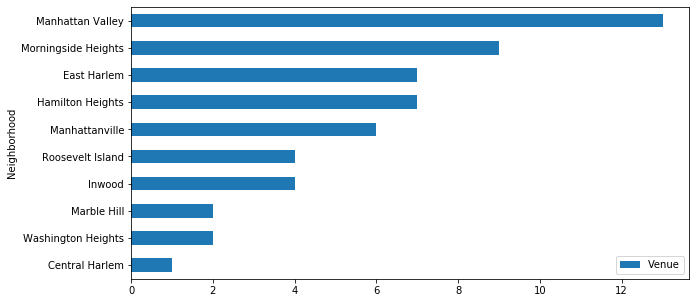

In [17]:
manhattan_venues.groupby('Neighborhood').count()\
    .sort_values(by=['Venue'])[['Venue']].head(10).plot(kind='barh', figsize=(10,5))

## Analyze Each Neighborhood

In [18]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

Neighborhood  American Restaurant  Asian Restaurant  Bagel Shop  Bakery  \
0  Marble Hill                    0                 0           0       0   
1  Marble Hill                    0                 0           0       0   
2    Chinatown                    0                 0           0       0   
3    Chinatown                    0                 0           0       0   
4    Chinatown                    0                 0           0       0   

   Bar  Belgian Restaurant  Breakfast Spot  Café  Chinese Restaurant  \
0    0                   0               0     0                   0   
1    0                   0               0     1                   0   
2    0                   0               0     0                   0   
3    0                   0               0     0                   0   
4    0                   0               0     0                   0   

   Cocktail Bar  Coffee Shop  Deli / Bodega  Dessert Shop  Dim Sum Restaurant  \
0             0            0              0             0                   0   
1             0            0              0             0                   0   
2             0            0              0             0                   0   
3             0            0              0             0                   0   
4             0            0              0             0                   0   

   Diner  Dumpling Restaurant  Food Court  Food Truck  Fried Chicken Joint  \
0      0                    0           0           0                    0   
1      0                    0           0           0                    0   
2      0                    0           0           0                    0   
3      0                    0           0           0                    0   
4      0                    0           0           0                    0   

   Gay Bar  Grocery Store  Japanese Restaurant  Juice Bar  \
0        0              0                    0          0   
1        0              0                    0          0   
2        0              0                    0          0   
3        0              0                    0          0   
4        0              0                    0          0   

   Latin American Restaurant  Malay Restaurant  New American Restaurant  \
0                          0                 0                        0   
1                          0                 0                        0   
2                          0                 0                        0   
3                          0                 0                        0   
4                          0                 0                        0   

   Noodle House  Pub  Ramen Restaurant  Restaurant  Salad Place  \
0             0    0                 0           0            0   
1             0    0                 0           0            0   
2             0    0                 0           0            0   
3             0    0                 0           0            0   
4             0    0                 0           0            0   

   Sandwich Place  Seafood Restaurant  Shanghai Restaurant  Snack Place  \
0               0                   0                    0            0   
1               0                   0                    0            0   
2               0                   0                    0            0   
3               0                   0                    0            0   
4               0                   0                    0            0   

   Soup Place  Sports Bar  Sushi Restaurant  Taco Place  Thai Restaurant  \
0           0           0                 0           0                1   
1           0           0                 0           0                0   
2           0           0                 0           0                1   
3           0           0                 0           0                1   
4           0           0                 0           0                1   

   Vegetarian / Vegan

In [19]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

Neighborhood  American Restaurant  Asian Restaurant  Bagel Shop  \
0     Battery Park City             0.000000          0.176471    0.000000   
1         Carnegie Hill             0.000000          0.037037    0.000000   
2        Central Harlem             0.000000          0.000000    0.000000   
3               Chelsea             0.000000          0.090909    0.000000   
4             Chinatown             0.000000          0.000000    0.000000   
5          Civic Center             0.000000          0.113636    0.000000   
6               Clinton             0.000000          0.023256    0.000000   
7           East Harlem             0.000000          0.000000    0.000000   
8          East Village             0.000000          0.022727    0.022727   
9    Financial District             0.000000          0.095238    0.000000   
10             Flatiron             0.000000          0.050847    0.000000   
11             Gramercy             0.000000          0.021739    0.021739   
12    Greenwich Village             0.000000          0.057143    0.000000   
13     Hamilton Heights             0.000000          0.000000    0.000000   
14         Hudson Yards             0.000000          0.000000    0.000000   
15               Inwood             0.000000          0.000000    0.000000   
16           Lenox Hill             0.000000          0.222222    0.000000   
17       Lincoln Square             0.000000          0.000000    0.000000   
18         Little Italy             0.000000          0.083333    0.000000   
19      Lower East Side             0.000000          0.038462    0.000000   
20     Manhattan Valley             0.000000          0.000000    0.000000   
21       Manhattanville             0.000000          0.166667    0.000000   
22          Marble Hill             0.000000          0.000000    0.000000   
23              Midtown             0.000000          0.037736    0.000000   
24        Midtown South             0.000000          0.017544    0.000000   
25  Morningside Heights             0.000000          0.111111    0.000000   
26          Murray Hill             0.000000          0.032787    0.000000   
27                 Noho             0.000000          0.019231    0.000000   
28     Roosevelt Island             0.000000          0.500000    0.000000   
29                 Soho             0.000000          0.073171    0.000000   
30      Stuyvesant Town             0.000000          0.058824    0.058824   
31         Sutton Place             0.038462          0.192308    0.000000   
32              Tribeca             0.000000          0.400000    0.000000   
33           Tudor City             0.000000          0.048780    0.000000   
34           Turtle Bay             0.022222          0.066667    0.000000   
35      Upper East Side             0.000000          0.047619    0.000000   
36      Upper West Side             0.000000          0.052632    0.000000   
37   Washington Heights             0.000000          0.000000    0.000000   
38         West Village             0.000000          0.081081    0.000000   
39            Yorkville             0.000000          0.037037    0.000000   

      Bakery       Bar  Belgian Restaurant  Breakfast Spot      Café  \
0   0.000000  0.000000            0.000000        0.000000  0.058824   
1   0.000000  0.000000            0.000000        0.000000  0.000000   
2   0.000000  1.000000            0.000000        0.000000  0.000000   
3   0.000000  0.000000            0.030303        0.030303  0.030303   
4   0.000000  0.000000            0.000000        0.000000  0.025641   
5   0.000000  0.000000            0.000000        0.000000  0.022727   
6   0.000000  0.046512            0.000000        0.000000  0.046512   
7   0.000000  0.000000            0.000000        0.000000  0.000000   
8   0.000000  0.000000            0.000000        0.000000  0.022727   
9   0.000000  0.000000            0.000000        0.000000  0.047619   
10  0.016949  0.0000

In [20]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                   venue  freq
0        Thai Restaurant  0.41
1       Asian Restaurant  0.18
2            Wings Joint  0.06
3  Vietnamese Restaurant  0.06
4                   Café  0.06


----Carnegie Hill----
                   venue  freq
0        Thai Restaurant  0.74
1  Vietnamese Restaurant  0.07
2     Seafood Restaurant  0.04
3       Sushi Restaurant  0.04
4            Salad Place  0.04


----Central Harlem----
                     venue  freq
0                      Bar   1.0
1      American Restaurant   0.0
2       Seafood Restaurant   0.0
3         Malay Restaurant   0.0
4  New American Restaurant   0.0


----Chelsea----
                           venue  freq
0                Thai Restaurant  0.64
1               Asian Restaurant  0.09
2  Vegetarian / Vegan Restaurant  0.06
3               Sushi Restaurant  0.06
4             Belgian Restaurant  0.03


----Chinatown----
                   venue  freq
0        Thai Restaurant  0.59
1  Vietnamese Restaur

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
0  Battery Park City       Thai Restaurant       Asian Restaurant   
1      Carnegie Hill       Thai Restaurant  Vietnamese Restaurant   
2     Central Harlem                   Bar            Wings Joint   
3            Chelsea       Thai Restaurant       Asian Restaurant   
4          Chinatown       Thai Restaurant  Vietnamese Restaurant   

           3rd Most Common Venue 4th Most Common Venue  \
0                    Wings Joint           Snack Place   
1                    Salad Place      Asian Restaurant   
2                    Coffee Shop   Fried Chicken Joint   
3  Vegetarian / Vegan Restaurant      Sushi Restaurant   
4               Malay Restaurant           Salad Place   

           5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0          Vietnamese Restaurant            Food Truck            Food Court   
1               Sushi Restaurant            Sports Bar    Seafood Restaurant   
2                     Food Truck            Food Court   Dumpling Restaurant   
3                 Breakfast Spot    Belgian Restaurant    Seafood Restaurant   
4  Vegetarian / Vegan Restaurant      Sushi Restaurant    Dim Sum Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                  Café   Fried Chicken Joint         Breakfast Spot  
1          Cocktail Bar   Dumpling Restaurant                  Diner  
2                 Diner    Dim Sum Restaurant           Dessert Shop  
3                  Café    Chinese Restaurant          Deli / Bodega  
4   Shanghai Restaurant    Seafood Restaurant            Coffee Shop

### Cluster neighborhoods

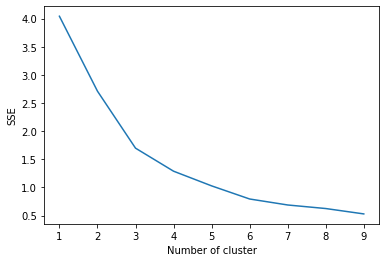

In [23]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(manhattan_grouped_clustering)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [24]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 3, 1, 1, 0, 2, 2, 2, 0], dtype=int32)

In [25]:
kmeans_labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan         Marble Hill  40.876551 -73.910660               4   
1  Manhattan           Chinatown  40.715618 -73.994279               1   
2  Manhattan  Washington Heights  40.851903 -73.936900               2   
3  Manhattan              Inwood  40.867684 -73.921210               2   
4  Manhattan    Hamilton Heights  40.823604 -73.949688               1   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0       Thai Restaurant                   Café           Wings Joint   
1       Thai Restaurant  Vietnamese Restaurant      Malay Restaurant   
2       Thai Restaurant            Wings Joint           Coffee Shop   
3       Thai Restaurant                   Café           Wings Joint   
4       Thai Restaurant    Japanese Restaurant                   Bar   

  4th Most Common Venue          5th Most Common Venue 6th Most Common Venue  \
0           Coffee Shop            Fried Chicken Joint            Food Truck   
1           Salad Place  Vegetarian / Vegan Restaurant      Sushi Restaurant   
2   Fried Chicken Joint                     Food Truck            Food Court   
3           Coffee Shop            Fried Chicken Joint            Food Truck   
4          Cocktail Bar                     Bagel Shop                Bakery   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Food Court   Dumpling Restaurant                 Diner   
1    Dim Sum Restaurant   Shanghai Restaurant    Seafood Restaurant   
2   Dumpling Restaurant                 Diner    Dim Sum Restaurant   
3            Food Court   Dumpling Restaurant                 Diner   
4   Fried Chicken Joint            Food Truck            Food Court   

  10th Most Common Venue  
0     Dim Sum Restaurant  
1            Coffee Shop  
2           Dessert Shop  
3     Dim Sum Restaurant  
4    Dumpling Restaurant

In [39]:
# create map
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="manhattan_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Model Interpret

In [28]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, 
                     manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue          2nd Most Common Venue  \
5       Manhattanville       Thai Restaurant            Japanese Restaurant   
23                Soho       Thai Restaurant          Vietnamese Restaurant   
24        West Village       Thai Restaurant  Vegetarian / Vegan Restaurant   
28   Battery Park City       Thai Restaurant               Asian Restaurant   
29  Financial District       Thai Restaurant                     Food Truck   
32        Civic Center       Thai Restaurant          Vietnamese Restaurant   

   3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
5                    Bar          Cocktail Bar       Asian Restaurant   
23      Asian Restaurant      Malay Restaurant                   Café   
24      Asian Restaurant      Sushi Restaurant     Chinese Restaurant   
28           Wings Joint           Snack Place  Vietnamese Restaurant   
29      Asian Restaurant           Snack Place             Food Court   
32      Asian Restaurant      Malay Restaurant     Chinese Restaurant   

            6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5                      Bagel Shop          Dessert Shop   Fried Chicken Joint   
23                    Salad Place        Sandwich Place   Shanghai Restaurant   
24                    Coffee Shop            Soup Place        Sandwich Place   
28                     Food Truck            Food Court                  Café   
29          Vietnamese Restaurant   Fried Chicken Joint                  Café   
32  Vegetarian / Vegan Restaurant           Wings Joint            Food Truck   

   9th Most Common Venue         10th Most Common Venue  
5             Food Truck                     Food Court  
23    Chinese Restaurant                    Coffee Shop  
24      Malay Restaurant        New American Restaurant  
28   Fried Chicken Joint                 Breakfast Spot  
29           Wings Joint  Vegetarian / Vegan Restaurant  
32   Fried Chicken Joint                  Grocery Store

In [29]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, 
                     manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue          2nd Most Common Venue  \
1             Chinatown       Thai Restaurant          Vietnamese Restaurant   
4      Hamilton Heights       Thai Restaurant            Japanese Restaurant   
8       Upper East Side       Thai Restaurant                    Salad Place   
9             Yorkville       Thai Restaurant          Vietnamese Restaurant   
10           Lenox Hill       Thai Restaurant               Asian Restaurant   
12      Upper West Side       Thai Restaurant             Chinese Restaurant   
13       Lincoln Square       Thai Restaurant                            Bar   
15              Midtown       Thai Restaurant  Vegetarian / Vegan Restaurant   
16          Murray Hill       Thai Restaurant                     Food Court   
17              Chelsea       Thai Restaurant               Asian Restaurant   
18    Greenwich Village       Thai Restaurant                    Salad Place   
22         Little Italy       Thai Restaurant               Asian Restaurant   
26  Morningside Heights       Thai Restaurant                    Salad Place   
33        Midtown South       Thai Restaurant  Vegetarian / Vegan Restaurant   
34         Sutton Place       Thai Restaurant               Asian Restaurant   
35           Turtle Bay       Thai Restaurant            Japanese Restaurant   
36           Tudor City       Thai Restaurant             Seafood Restaurant   
38             Flatiron       Thai Restaurant  Vegetarian / Vegan Restaurant   

            3rd Most Common Venue          4th Most Common Venue  \
1                Malay Restaurant                    Salad Place   
4                             Bar                   Cocktail Bar   
8                Asian Restaurant               Sushi Restaurant   
9                     Salad Place               Asian Restaurant   
10            Japanese Restaurant             Seafood Restaurant   
12                    Salad Place                            Pub   
13               Sushi Restaurant                           Café   
15                     Food Court               Asian Restaurant   
16            Japanese Restaurant  Vegetarian / Vegan Restaurant   
17  Vegetarian / Vegan Restaurant               Sushi Restaurant   
18               Asian Restaurant               Sushi Restaurant   
22          Vietnamese Restaurant               Malay Restaurant   
26               Asian Restaurant                   Dessert Shop   
33                           Café               Sushi Restaurant   
34            Japanese Restaurant             Seafood Restaurant   
35               Asian Restaurant             Seafood Restaurant   
36            Japanese Restaurant               Asian Restaurant   
38               Asian Restaurant                     Food Truck   

            5th Most Common Venue  6th Most Common Venue  \
1   Vegetarian / Vegan Restaurant       Sushi Restaurant   
4                      Bagel Shop                 Bakery   
8                      Sports Bar  Vietnamese Restaurant   
9                Sushi Restaurant             Sports Bar   
10             Chinese Restaurant                 Bakery   
12  Vegetarian / Vegan Restaurant       Asian Restaurant   
13                    Salad Place            Wings Joint   
15                           Café    Japanese Restaurant   
16               Asian Restaurant     Seafood Restaurant   
17                 Breakfast Spot     Belgian Restaurant   
18                     Soup Place       Malay Restaurant   
22                           Café            Salad Place   
26                    Wings Joint             Food Truck   
33                            Bar             Food Truck   
34                 Breakfast Spot                   Café   
35                     Food Court            Salad Place   
36                     Food Court       Sushi Restaurant   
38               Sushi Restaurant            Salad Place   

            7th Most Common Venue      8th Most Common V

In [30]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, 
                     manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
2   Washington Heights       Thai Restaurant            Wings Joint   
3               Inwood       Thai Restaurant                   Café   
7          East Harlem       Thai Restaurant            Wings Joint   
14             Clinton       Thai Restaurant                    Bar   
19        East Village       Thai Restaurant     Chinese Restaurant   
20     Lower East Side       Thai Restaurant           Cocktail Bar   
25    Manhattan Valley       Thai Restaurant           Dessert Shop   
27            Gramercy       Thai Restaurant             Food Truck   
30       Carnegie Hill       Thai Restaurant  Vietnamese Restaurant   
31                Noho       Thai Restaurant                   Café   
37     Stuyvesant Town       Thai Restaurant           Cocktail Bar   
39        Hudson Yards       Thai Restaurant     Chinese Restaurant   

            3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2                     Coffee Shop   Fried Chicken Joint            Food Truck   
3                     Wings Joint           Coffee Shop   Fried Chicken Joint   
7                     Coffee Shop   Fried Chicken Joint            Food Truck   
14                           Café      Asian Restaurant          Noodle House   
19               Asian Restaurant            Taco Place            Bagel Shop   
20             Chinese Restaurant      Asian Restaurant      Sushi Restaurant   
25                    Wings Joint           Coffee Shop   Fried Chicken Joint   
27  Vegetarian / Vegan Restaurant      Asian Restaurant            Bagel Shop   
30                    Salad Place      Asian Restaurant      Sushi Restaurant   
31                    Salad Place      Asian Restaurant            Taco Place   
37               Asian Restaurant            Bagel Shop          Dessert Shop   
39  Vegetarian / Vegan Restaurant                   Bar                  Café   

   6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
2             Food Court    Dumpling Restaurant                 Diner   
3             Food Truck             Food Court   Dumpling Restaurant   
7             Food Court    Dumpling Restaurant                 Diner   
14               Gay Bar            Wings Joint          Dessert Shop   
19   Dumpling Restaurant                   Café          Cocktail Bar   
20           Coffee Shop             Food Truck            Food Court   
25            Food Truck             Food Court   Dumpling Restaurant   
27                Bakery                    Bar             Juice Bar   
30            Sports Bar     Seafood Restaurant          Cocktail Bar   
31      Sushi Restaurant  Vietnamese Restaurant      Malay Restaurant   
37         Deli / Bodega    Fried Chicken Joint            Food Truck   
39          Noodle House          Deli / Bodega            Food Truck   

   9th Most Common Venue 10th Most Common Venue  
2     Dim Sum Restaurant           Dessert Shop  
3                  Diner     Dim Sum Restaurant  
7     Dim Sum Restaurant           Dessert Shop  
14            Food Truck             Food Court  
19          Dessert Shop          Deli / Bodega  
20   Dumpling Restaurant                  Diner  
25                 Diner     Dim Sum Restaurant  
27   Dumpling Restaurant                  Diner  
30   Dumpling Restaurant                  Diner  
31          Dessert Shop           Cocktail Bar  
37            Food Court    Dumpling Restaurant  
39            Food Court    Dumpling Restaurant

In [31]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, 
                     manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
6  Central Harlem                   Bar           Wings Joint   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
6           Coffee Shop   Fried Chicken Joint            Food Truck   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
6            Food Court   Dumpling Restaurant                 Diner   

  9th Most Common Venue 10th Most Common Venue  
6    Dim Sum Restaurant           Dessert Shop

In [32]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, 
                     manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Marble Hill       Thai Restaurant                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Wings Joint           Coffee Shop   Fried Chicken Joint   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Food Truck            Food Court   Dumpling Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0                 Diner     Dim Sum Restaurant

In [33]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, 
                     manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
11  Roosevelt Island      Asian Restaurant       Thai Restaurant   
21           Tribeca      Asian Restaurant        Sandwich Place   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
11    Chinese Restaurant           Wings Joint         Deli / Bodega   
21       Thai Restaurant            Soup Place                  Café   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
11   Fried Chicken Joint            Food Truck            Food Court   
21           Snack Place           Wings Joint            Food Truck   

   9th Most Common Venue 10th Most Common Venue  
11   Dumpling Restaurant                  Diner  
21                   Bar                 Bakery

In [34]:
manhattan_venues[manhattan_venues['Neighborhood']=='Central Harlem']

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
60  Central Harlem              40.815976              -73.943211   

                Venue  Venue Latitude  Venue Longitude Venue Category  
60  Grill On The Hill       40.822177       -73.949944            Bar

In [35]:
manhattan_venues[manhattan_venues['Neighborhood']=='Marble Hill']

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551               -73.91066   
1  Marble Hill              40.876551               -73.91066   

              Venue  Venue Latitude  Venue Longitude   Venue Category  
0       Siam Square       40.878796       -73.916701  Thai Restaurant  
1  Indian Road Café       40.872922       -73.918459             Café

In [36]:
manhattan_venues[manhattan_venues['Neighborhood']=='Roosevelt Island']

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
134  Roosevelt Island               40.76216              -73.949168   
135  Roosevelt Island               40.76216              -73.949168   
136  Roosevelt Island               40.76216              -73.949168   
137  Roosevelt Island               40.76216              -73.949168   

                          Venue  Venue Latitude  Venue Longitude  \
134  Ahana Asian Fusion Cuisine       40.762261       -73.960123   
135                   The Buffs       40.755454       -73.941367   
136       Hunan Delight Matsuya       40.770742       -73.950970   
137                       Ayama       40.762593       -73.959953   

         Venue Category  
134    Asian Restaurant  
135     Thai Restaurant  
136  Chinese Restaurant  
137    Asian Restaurant

In [37]:
manhattan_venues[manhattan_venues['Neighborhood']=='Tribeca']

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
466      Tribeca              40.721522              -74.010683   
467      Tribeca              40.721522              -74.010683   
468      Tribeca              40.721522              -74.010683   
469      Tribeca              40.721522              -74.010683   
470      Tribeca              40.721522              -74.010683   
471      Tribeca              40.721522              -74.010683   
472      Tribeca              40.721522              -74.010683   
473      Tribeca              40.721522              -74.010683   
474      Tribeca              40.721522              -74.010683   
475      Tribeca              40.721522              -74.010683   
476      Tribeca              40.721522              -74.010683   
477      Tribeca              40.721522              -74.010683   
478      Tribeca              40.721522              -74.010683   
479      Tribeca              40.721522              -74.010683   
480      Tribeca              40.721522              -74.010683   

                               Venue  Venue Latitude  Venue Longitude  \
466                           Khe-Yo       40.716753       -74.008584   
467                Macao Trading Co.       40.719759       -74.003981   
468                   Mooncake Foods       40.723552       -74.004264   
469                        Soho Thai       40.720117       -73.999504   
470                  Mulberry & Vine       40.715177       -74.010227   
471  Mudville Restaurant & Tap House       40.715336       -74.008881   
472                         Wei West       40.715079       -74.014810   
473                    Bo.lan Pop-up       40.727285       -74.008788   
474                     Arbor Bistro       40.728660       -74.004815   
475             Accord Asian Cuisine       40.713619       -74.005921   
476                    Pret A Manger       40.727391       -74.007239   
477                      Fatty Snack       40.713993       -74.015846   
478                Big D's Khao Cart       40.727962       -74.007229   
479                    Hale & Hearty       40.727463       -74.007247   
480                   Deb's Catering       40.728284       -74.005386   

       Venue Category  
466  Asian Restaurant  
467  Asian Restaurant  
468  Asian Restaurant  
469   Thai Restaurant  
470              Café  
471       Wings Joint  
472  Asian Restaurant  
473   Thai Restaurant  
474  Asian Restaurant  
475  Asian Restaurant  
476    Sandwich Place  
477       Snack Place  
478        Food Truck  
479        Soup Place  
480    Sandwich Place